In [1]:
# Impoting all the necessary library required 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,LSTM,GlobalMaxPooling1D,Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix
import re,string,nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

df2=pd.read_csv('Twitter_Data.csv')
df1=pd.read_csv('Reddit_Data.csv')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
df1.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [3]:
#renaming the columns
df2.columns=['messages','labels']
df1.columns=['messages','labels']

In [4]:
df1.head()

,messages,labels
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [5]:
df2.head()

,messages,labels
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


## merging both the dataset

In [6]:
df = pd.concat([df1, df2], ignore_index = True)

In [7]:
df['messages'].iloc[0] #iloc is used to select a row

' family mormon have never tried explain them they still stare puzzled from time time like some kind strange creature nonetheless they have come admire for the patience calmness equanimity acceptance and compassion have developed all the things buddhism teaches '

In [8]:
df['messages'].iloc[100]

' want move gujarat and live there for few months any city that you can recommend '

In [9]:
df.head()

,messages,labels
0,family mormon have never tried explain them t...,1.0
1,buddhism has very much lot compatible with chr...,1.0
2,seriously don say thing first all they won get...,-1.0
3,what you have learned yours and only yours wha...,0.0
4,for your own benefit you may want read living ...,1.0


In [10]:
df.tail()

,messages,labels
200224,why these 456 crores paid neerav modi not reco...,-1.0
200225,dear rss terrorist payal gawar what about modi...,-1.0
200226,did you cover her interaction forum where she ...,0.0
200227,there big project came into india modi dream p...,0.0
200228,have you ever listen about like gurukul where ...,1.0


In [11]:
df['length']=df['messages'].str.len()

<AxesSubplot: ylabel='Frequency'>

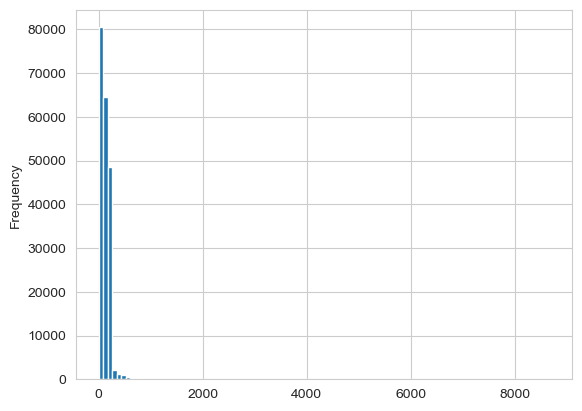

In [12]:
sns.set_style('whitegrid')
df['length'].plot(kind='hist',bins=100,)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200229 entries, 0 to 200228
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   messages  200125 non-null  object 
 1   labels    200222 non-null  float64
 2   length    200125 non-null  float64
dtypes: float64(2), object(1)
memory usage: 4.6+ MB


In [14]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
labels,200222.0,0.221219,0.780813,-1.0,0.0,0.0,1.0,1.0
length,200125.0,134.796737,167.639234,1.0,61.0,109.0,183.0,8665.0


In [15]:
#from the describe function we got to know that the longest message is of length 8665
df[df['length']==8665]['messages'].iloc[0]

'brilliant point point breakdown one other argument making the rounds false argument okay maybe the strikes took place but should have been kept secret and deniable there good reason for dgmo make statements about covert actions except for bjp score political points there are massive number reasons make strike like this public exposes pakistan bluster just tough talk for all their talk being high alert for indian troop movement along the loc after the uri attack they didn even see coming massively boosts morale within the armed forces morale which has been getting steadily lower our bases kept getting hit while they were not allowed take charge the offensive the troops are also being vilified the media national and international while trying control spiral violence srinagar fueled pakistan propaganda machine makes the best use pakistan blunder overreaching and outmaneuvers them pakistan has its hands tied now after making bold statements about defending against indian adventurism aggre

In [16]:
# mapping the labels to their respective meanings
df['labels']=df['labels'].map({-1:'negative',0:'neutral',1:'positive'})

In [17]:
#checking the null values in the dataset
df.isnull().sum()

messages    104
labels        7
length      104
dtype: int64

In [18]:
#removing the null value witg dropna()
df=df.dropna()

In [19]:
len(df['messages'])

200118

In [20]:
#cleaning the data from unnecessary data

#replacing url with string URL
def replace_url(text):
    return re.sub('https?:\/\/\S*|www\.\S+','URL',text)

#removing html
def remove_html(text):
    return re.sub('<.*?>','',text)

#replacing mentions with string user
def replace_mentions(text):
    return re.sub('@\S*','user',text,flags=re.IGNORECASE)

#replacing numbers with string number
def replace_num(text):
    return re.sub('^[+-]*?\d{1,3}[- ]*?\d{1,10}|\d{10}','NUMBER',text)

#replacing <3 with sring heart
def replace_heart(text):
    return re.sub('<3','HEART', text)

#removing alphanumeric characters eg-XYZ123ABC
def remove_alphanumeric(text):
    return re.sub('\w*\d+\w*','',text)

#removing all english stopwords 
def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in stopwords.words("english")])
    return text

#removing punctuations
def remove_punctuations(text):
    text=''.join([word for word in text if word not in string.punctuation])
    return text

#reducing words to thier root form
def lemmatization(text):
    lm= WordNetLemmatizer()
    text = ' '.join([lm.lemmatize(word, pos='v') for word in text.split()])
    return text

In [21]:
def clean_text(text):
    text=str(text).lower()
    text = replace_url(text)
    text = remove_html(text)
    text = replace_mentions(text)
    text = replace_num(text)
    text = replace_heart(text)
    text = remove_alphanumeric(text)
    text = remove_stopwords(text)
    text=remove_punctuations(text)
    #text=stemming(text)
    text=lemmatization(text)
    return text

In [22]:
df['messages1']=df['messages'].apply(clean_text)

In [23]:
df['messages1']

0         family mormon never try explain still stare pu...
1         buddhism much lot compatible christianity espe...
2         seriously say thing first get complex explain ...
3         learn want teach different focus goal wrap pap...
4         benefit may want read live buddha live christ ...
                                ...                        
200224    crores pay neerav modi recover congress leader...
200225    dear rss terrorist payal gawar modi kill plus ...
200226                        cover interaction forum leave
200227    big project come india modi dream project happ...
200228    ever listen like gurukul discipline maintain e...
Name: messages1, Length: 200118, dtype: object

In [24]:
#splitting the data for training and testing
X=df['messages1'].values
y = pd.get_dummies(df['labels']).values
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33)

In [25]:
X_train.shape

(134079,)

In [26]:
#converting the messages into tokens and then converting them into matrix of integers
Max_vocab_size=50000
tokenizer=Tokenizer(num_words=Max_vocab_size)
tokenizer.fit_on_texts(X_train)
sequence_Xtrain=tokenizer.texts_to_sequences(X_train)
sequence_Xtest=tokenizer.texts_to_sequences(X_test)

In [27]:
V=len(tokenizer.word_index)

In [28]:
#padding the integer matrix with zero so that all the data have the same length 
data_train=pad_sequences(sequence_Xtrain)

In [29]:
T=data_train.shape[1]
print(T)

866


In [30]:
data_test=pad_sequences(sequence_Xtest,maxlen=T)

In [31]:
data_train.shape

(134079, 866)

In [32]:
data_test.shape

(66039, 866)

In [33]:
D=20 #No of features you want 
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=25)
i=Input(shape=(T,))
x=Embedding(V+1,D)(i)
x=LSTM(128,dropout=(0.2))(x)
x=Dense(3,activation='softmax')(x)
model=Model(i,x)
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(data_train,y_train,batch_size=128,validation_data=(data_test,y_test),epochs=5)

Epoch 1/5
1048/1048 [==============================] - 110s 100ms/step - loss: 0.5465 - accuracy: 0.7828 - val_loss: 0.3673 - val_accuracy: 0.8750
Epoch 2/5
1048/1048 [==============================] - 104s 99ms/step - loss: 0.3315 - accuracy: 0.8865 - val_loss: 0.3542 - val_accuracy: 0.8819
Epoch 3/5
1048/1048 [==============================] - 105s 100ms/step - loss: 0.2882 - accuracy: 0.9020 - val_loss: 0.3625 - val_accuracy: 0.8801
Epoch 4/5
1048/1048 [==============================] - 105s 100ms/step - loss: 0.2625 - accuracy: 0.9115 - val_loss: 0.3655 - val_accuracy: 0.8748
Epoch 5/5
1048/1048 [==============================] - 104s 100ms/step - loss: 0.2414 - accuracy: 0.9190 - val_loss: 0.3852 - val_accuracy: 0.8729


In [34]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 866)]             0         
                                                                 
 embedding (Embedding)       (None, 866, 20)           1854460   
                                                                 
 lstm (LSTM)                 (None, 128)               76288     
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 1,931,135
Trainable params: 1,931,135
Non-trainable params: 0
_________________________________________________________________


In [35]:
#evaluating the model performance
model.evaluate(data_test,y_test)

2064/2064 [==============================] - 63s 31ms/step - loss: 0.3852 - accuracy: 0.8729


[0.38522467017173767, 0.8729084134101868]

<AxesSubplot: >

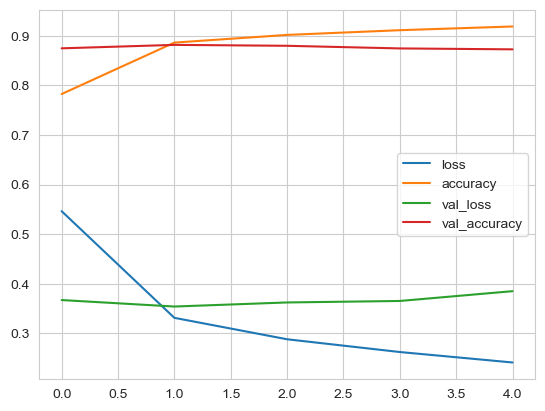

In [36]:
losses=pd.DataFrame(history.history)
losses.plot()

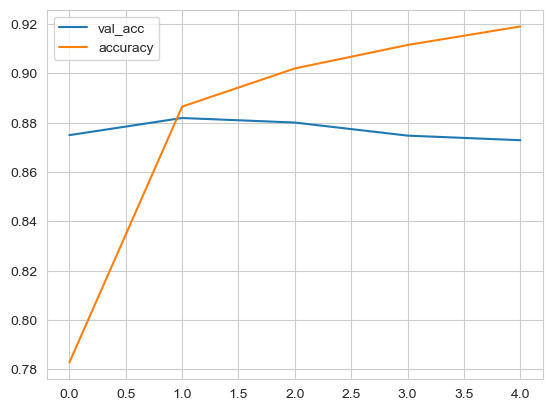

In [37]:
plt.plot(history.history['val_accuracy'],label='val_acc')
plt.plot(history.history['accuracy'],label='accuracy')
plt.legend()

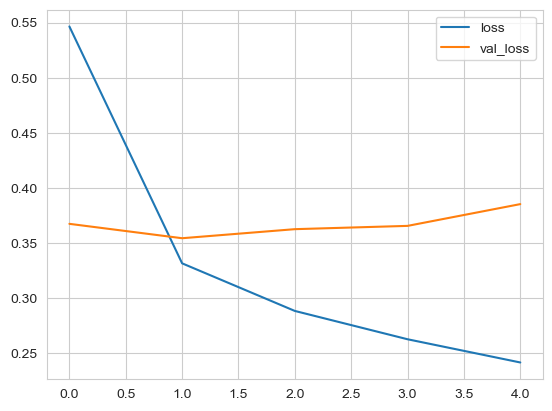

In [38]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()

In [39]:
predictions=model.predict(data_test).argmax(axis=1)

2064/2064 [==============================] - 63s 30ms/step


In [40]:
print(classification_report(y_test.argmax(axis=1),predictions))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81     14260
           1       0.88      0.90      0.89     22570
           2       0.89      0.89      0.89     29209

    accuracy                           0.87     66039
   macro avg       0.86      0.86      0.86     66039
weighted avg       0.87      0.87      0.87     66039



In [41]:
model.save('model#1.h5')